In [132]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch_optimizer import Lookahead
import seaborn as sns

sns.set_style('darkgrid')


In [133]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, index_col=0, parse_dates=True)

# Дополнительные признаки
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['diff'] = df['Passengers'].diff()
df['rolling_mean'] = df['Passengers'].rolling(window=3).mean()
df.fillna(0, inplace=True)

# Нормализация
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Passengers', 'month', 'dayofweek', 'diff', 'rolling_mean']])

# Функция создания последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [134]:
seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

# Разделение на train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразование в тензоры
X_train_tensors = torch.FloatTensor(X_train)
y_train_tensors = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensors = torch.FloatTensor(X_test)
y_test_tensors = torch.FloatTensor(y_test).unsqueeze(1)


In [135]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=256, num_layers=5, output_size=1, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True  # Двунаправленная LSTM
        )

        self.norm = nn.LayerNorm(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)  

    def forward(self, x):
        device = x.device

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.norm(out[:, -1, :])
        out = self.fc(out)  
        return out


In [136]:
model = LSTMModel()

# Функция потерь и оптимизатор
criterion = nn.MSELoss()
base_optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)  # Lookahead для стабильности

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Предсказание модели
    outputs = model(X_train_tensors)
    
    # Вычисление ошибки
    loss = criterion(outputs, y_train_tensors)
    
    # Обратное распространение ошибки
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


# Оценка модели
model.eval()
y_pred = model(X_test_tensors).detach().numpy()
y_pred = y_pred[:, 0].reshape(-1, 1)


Epoch 10/300, Loss: 0.18857283890247345
Epoch 20/300, Loss: 0.04261723533272743
Epoch 30/300, Loss: 0.030569840222597122
Epoch 40/300, Loss: 0.02876722253859043
Epoch 50/300, Loss: 0.027978288009762764
Epoch 60/300, Loss: 0.02571776881814003
Epoch 70/300, Loss: 0.02230273373425007
Epoch 80/300, Loss: 0.010985944420099258
Epoch 90/300, Loss: 0.007818963378667831
Epoch 100/300, Loss: 0.005135436076670885
Epoch 110/300, Loss: 0.0048185172490775585
Epoch 120/300, Loss: 0.004884807392954826
Epoch 130/300, Loss: 0.004325364716351032
Epoch 140/300, Loss: 0.0036382568068802357
Epoch 150/300, Loss: 0.003974907100200653
Epoch 160/300, Loss: 0.003166281385347247
Epoch 170/300, Loss: 0.00360254873521626
Epoch 180/300, Loss: 0.0037176995538175106
Epoch 190/300, Loss: 0.002993948059156537
Epoch 200/300, Loss: 0.0031772919464856386
Epoch 210/300, Loss: 0.0031121778301894665
Epoch 220/300, Loss: 0.0032499234657734632
Epoch 230/300, Loss: 0.0028038169257342815
Epoch 240/300, Loss: 0.0024690432474017143

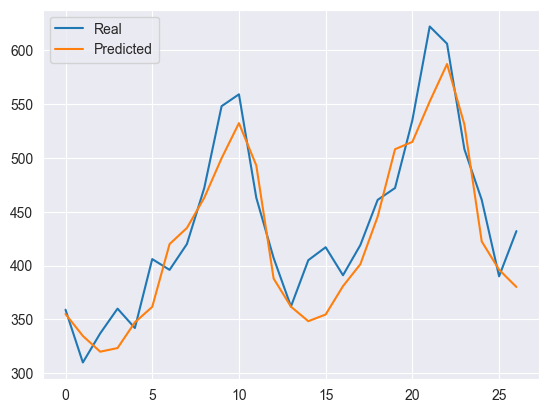

In [137]:
y_test_inv = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1)] * 5))[:, 0]
y_pred_inv = scaler.inverse_transform(np.hstack([y_pred.reshape(-1, 1)] * 5))[:, 0]

plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.show()
